## ABOUT

### Section 1: Data loading and trasnformations

In [1]:
# %pip install lightgbm
# %pip install seaborn
# %pip install Prophet
%pip install -r  "Requirements.txt"

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for Prophet from https://files.pythonhosted.org/packages/24/2b/834e9a347f2f0161e32a3c6125b8a1ebdf6ac33199a0ed3a0bdf1f0c296f/prophet-1.1.5-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/81/d7/d2537d51efb692d0c411e64267ba349e7668d40f5bc73cefe78ccd650dcd/scipy-1.11.3-cp311-cp311-win_amd64.whl.metadata
  Using cached scipy-1.11.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Obtaining dependency information for matplotlib!=3.6.1,>=3.3 from https://files.pythonhosted.org/packages/40/d

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'c:\\Python311\\share\\man\\man1\\ttx.1'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# import os
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'lightgbm'

In [7]:
#information on holiday dataset

holidays = pd.read_csv('/home/ec2-user/SageMaker/Datasets/holidays_events.csv')
sorted_hols = holidays.sort_values(['date', 'locale'])
del holidays
sorted_hols = sorted_hols.drop_duplicates(subset=['date'], keep='last')

#information on stores dataset
stores = pd.read_csv('/home/ec2-user/SageMaker/Datasets/stores.csv')

In [8]:
train = pd.read_csv('/home/ec2-user/SageMaker/Datasets/train.csv', index_col='id')
temp = train.merge(stores,
                   on='store_nbr',
                   how='left')

In [9]:
National_holidays = sorted_hols.loc[sorted_hols['locale'] == 'National'].drop(['locale_name','locale'], axis='columns')
# National_holidays.head()
Regional_holidays = sorted_hols.loc[sorted_hols['locale'] == 'Regional'].drop(['locale'], axis='columns')
# Regional_holidays.head()
Local_holidays = sorted_hols.loc[sorted_hols['locale'] == 'Local'].drop(['locale'], axis='columns')
# Local_holidays.head()

In [10]:
# reseting all holidays
Local_holidays.shape
National_holidays = National_holidays.reset_index(drop=True)
Regional_holidays = Regional_holidays.reset_index(drop=True)
Local_holidays = Local_holidays.reset_index(drop=True)

In [11]:
test = temp.merge(National_holidays, how='left', on='date')
test = test.dropna()

In [12]:
test1 = temp.merge(Regional_holidays, how='right', left_on=['date','state'],right_on=['date', 'locale_name'])
test1 = test1.dropna()
test1 = test1.drop(['locale_name'], axis='columns')

In [13]:
test2 = temp.merge(Local_holidays, how='right', left_on=['date','city'],right_on=['date', 'locale_name'])
test2 = test2.dropna()
test2 = test2.drop(['locale_name'], axis='columns')

In [14]:
array = [test, test1, test2]
result = pd.concat(array)


In [15]:
# del test
# del test1
# del test2
# del array

In [16]:
result = result.rename(columns={"type_x": "type", "type_y": "holiday_type"})

In [17]:
cols = list(temp.columns)

In [18]:
output = temp.merge(result, how='left', on=cols)


In [19]:
del temp
del cols

In [20]:
# output.to_csv('/home/ec2-user/SageMaker/Datasets/formatted.csv')

In [21]:
# output['test'] = output.holiday_type + " - " + output.description
output = output.drop(['description', 'cluster', 'transferred', 'state', 'holiday_type', 'type'], axis='columns')
# output.test.nunique()

In [22]:
output.date = pd.to_datetime(output.date)
# output.date
# output.date.map(lambda d: pd.to_datetime(d))

In [23]:
output['week'] = output['date'].dt.isocalendar().week
output['year'] =  output['date'].dt.strftime("%Y")
output['month'] =  output['date'].dt.strftime("%m")

In [24]:
# output.to_csv('/home/ec2-user/SageMaker/Datasets/check.csv')
output = output.loc[output.date.dt.year > 2013]

In [25]:
year_split = 2016
temp = output.loc[output.date.dt.year <= year_split]
train = temp.copy()
del temp
train.set_index(['store_nbr'],inplace=True)

s = (train.dtypes == 'object')
cat_cols = list(s[s].index)
train[cat_cols] = train[cat_cols].astype('category')

X = train.copy()
X.drop(['sales', 'date'], inplace=True, axis='columns')
# train.head()
y = train.sales


In [26]:
temp = output[output.date.dt.year > year_split]
valid = temp.copy()
del temp
valid.set_index(['store_nbr'],inplace=True)


s = (valid.dtypes == 'object')
cat_cols = list(s[s].index)
valid[cat_cols] = valid[cat_cols].astype('category')

valid_actual = valid.sales
valid.drop(['sales', 'date'], inplace=True, axis='columns')


In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [28]:
#Model training
hyper_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'MAPE',
    'num_leaves': 32,
    'learning_rate': 0.2,
    'verbose': 1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
model = lgb.train(hyper_params, train_set=lgb_train, num_boost_round=500, valid_sets=lgb_eval)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 1558180, number of used features: 6
[LightGBM] [Info] Start training from score 378.845693


In [29]:
#Model Predictions
y_pred = model.predict(valid)
print(y_pred)
# RMSE = np.sqrt(np.mean(np.square((test_actual - y_pred))))
# print(RMSE)
# train.sales.mean()
y_pred = pd.Series(y_pred, name='predictions')
# test.shape
output.reset_index(inplace=True)


[  -4.34838096  -13.78674818   -9.01538751 ... 1834.31607842  111.99739513
   33.67273935]


In [30]:
temp = y.copy()
temp[:] = np.nan
temp.reset_index(drop=True, inplace=True)
temp1 = pd.concat([temp, y_pred])
temp1.reset_index(drop=True, inplace=True)
output = pd.concat([output,temp1], axis=1)
del temp
del temp1
# temp = pd.Series([])


In [31]:
output.rename(columns={0: 'predictions'}, inplace=True)


In [32]:
output.head()

,index,date,store_nbr,family,sales,onpromotion,city,week,year,month,predictions
0,648648,2014-01-01,1,AUTOMOTIVE,0.0,0,Quito,1,2014,01,NaN
1,648649,2014-01-01,1,BABY CARE,0.0,0,Quito,1,2014,01,NaN
2,648650,2014-01-01,1,BEAUTY,0.0,0,Quito,1,2014,01,NaN
3,648651,2014-01-01,1,BEVERAGES,0.0,0,Quito,1,2014,01,NaN
4,648652,2014-01-01,1,BOOKS,0.0,0,Quito,1,2014,01,NaN


In [33]:
# temp.to_csv('/home/ec2-user/SageMaker/Datasets/predictions.csv')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

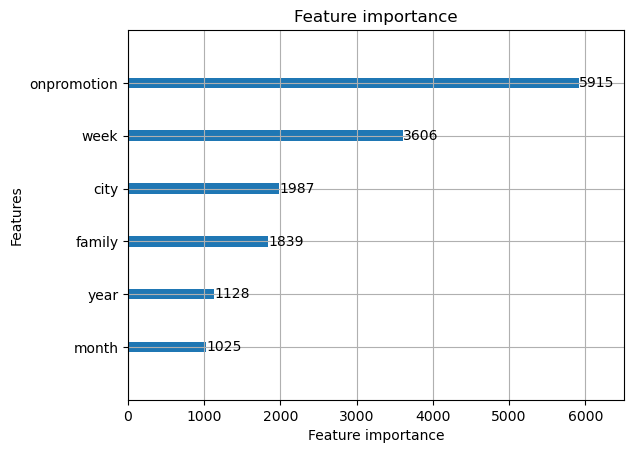

In [34]:
lgb.plot_importance(model)

In [35]:
sales = output.groupby(['year', 'month'])[['sales', 'predictions']].sum()
MAPE = mean_absolute_percentage_error(sales.sales, sales.predictions)
print(MAPE)

0.8251146448060747


In [36]:
sales.reset_index(inplace=True)
sales['date'] = sales.year + "-" + sales.month
sales.drop(['year', 'month'], axis='columns', inplace=True)

([<matplotlib.axis.XTick at 0x7fe2d38ca800>,
 [Text(0, 0, '2014-01'),
  Text(7, 0, '2014-08'),
  Text(14, 0, '2015-03'),
  Text(21, 0, '2015-10'),
  Text(28, 0, '2016-05'),
  Text(35, 0, '2016-12'),
  Text(42, 0, '2017-07')])

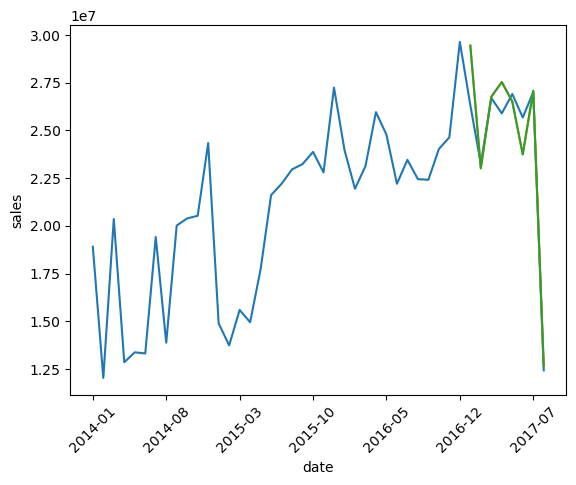

In [37]:
#Graphing 
x_temp = sales.loc[sales['predictions']!=0, :]
sns.lineplot(data=sales, x='date', y='sales')
sns.lineplot(data=x_temp, x='date', y='predictions')
sns.lineplot(data=x_temp, x='date', y='predictions')
# plt.xticks(sales.year)
num_ticks = 7  # Choose the desired number of ticks
x_tick_positions = range(0, len(sales), len(sales) // (num_ticks - 1))
x_tick_labels = [sales['date'].iloc[pos] for pos in x_tick_positions]
plt.xticks(x_tick_positions, x_tick_labels, rotation=45)

<Axes: xlabel='date', ylabel='sales'>

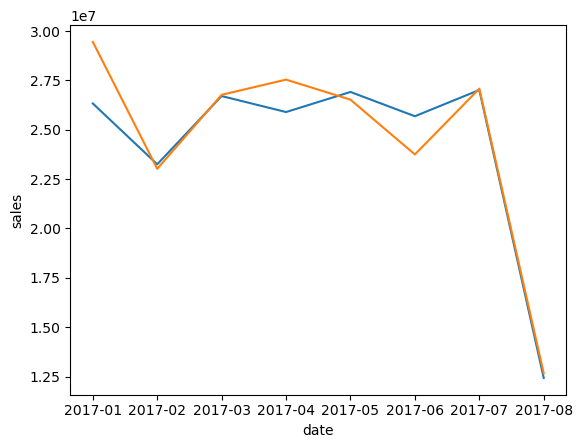

In [38]:
x_temp = sales.loc[sales['predictions']!=0, :]
sns.lineplot(data=x_temp, x='date', y='sales')
sns.lineplot(data=x_temp, x='date', y='predictions')

In [39]:
output.to_csv('/home/ec2-user/SageMaker/Datasets/nice_graph.csv')

In [40]:
sales.to_csv('/home/ec2-user/SageMaker/Datasets/test_test.csv')

In [41]:
temp2 = output[output.store_nbr == 50]

In [42]:
temp3 = temp2.groupby(['year', 'month'])[['sales', 'predictions']].sum()
temp3.reset_index(inplace=True)
temp3['date'] = temp3.year + "-" + temp3.month
temp3.drop(['year', 'month'], axis='columns', inplace=True)

<Axes: xlabel='date', ylabel='sales'>

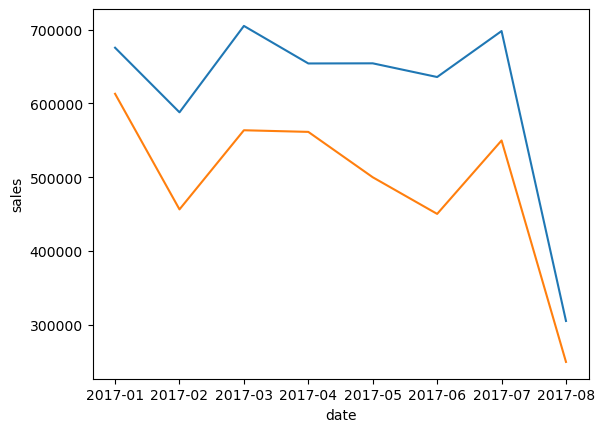

In [43]:
x_temp = temp3.loc[sales['predictions']!=0, :]
sns.lineplot(data=x_temp, x='date', y='sales')
sns.lineplot(data=x_temp, x='date', y='predictions')
